In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
print(recent_date)

2017-08-23


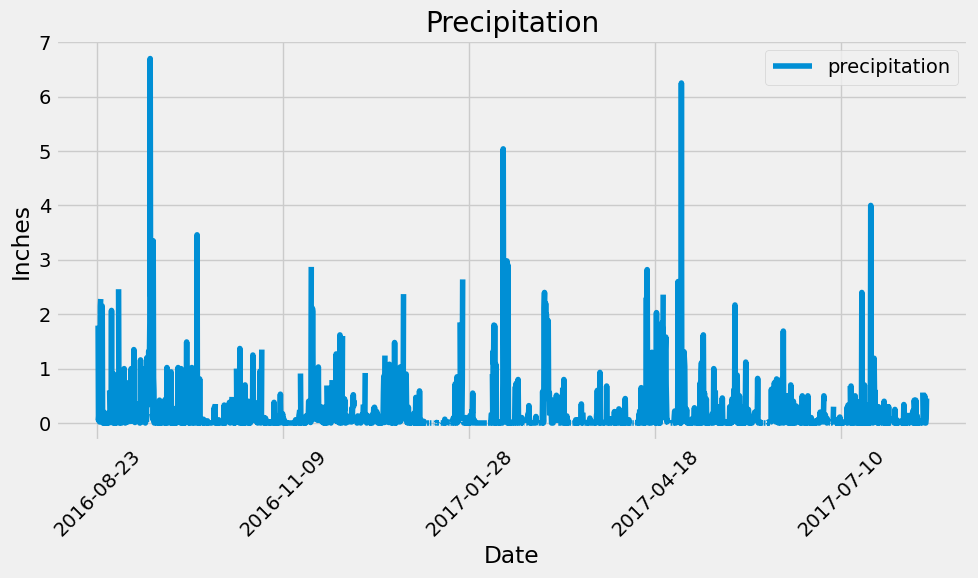

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(func.max(measurement.date)).scalar()
last_date = pd.to_datetime(last_date)
one_year_ago = last_date - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df = precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x='date', y='precipitation', figsize=(10,6), title="Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precip_df['precipitation'].describe()
precip_summary_df = pd.DataFrame(precipitation_summary)
precip_summary_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(station.station)).scalar()
print(station_count)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station).label('count'))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc()).all()

for station, count in active_stations:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

temperature_stats = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).filter(measurement.station == most_active).all()

min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Station: {most_active}")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Station: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


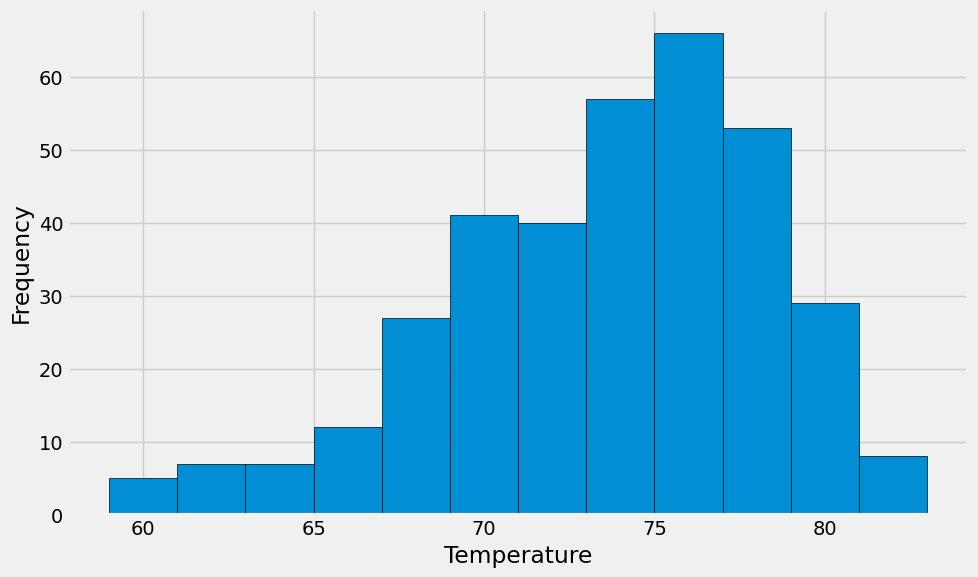

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_date = session.query(func.max(measurement.date)).scalar()
last_date = pd.to_datetime(last_date)
one_year_ago = last_date - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')

temperature_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active).\
    filter(measurement.date >= one_year_ago).all()

temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])

plt.figure(figsize=(10,6))
plt.hist(temperature_df['temperature'], bins=12, edgecolor='black')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()